In [1]:
import warnings
warnings.filterwarnings('ignore') 

import numpy as np
import pandas as pd
from collections import Counter
import cv2, os
from tqdm import tqdm
from random import shuffle
import shutil
import re
import datetime
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn import utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from wandb.keras import WandbCallback
import imgaug.augmenters as iaa

# Importing Modules

In [25]:
%load_ext autoreload
%autoreload 2

In [29]:
from data_generator import *
from functions_generator import *

In [100]:
from customized_adaboost import AdaBoostClassifier as Ada_CNN


In [86]:
from constants import *

# Wandb

In [69]:
# For MLOps
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback
wandb.login(key='236eaeacc7d9dd51a618dca240c24e304f5ad256',relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\UsuarioHI/.netrc


W&B:  0.13.5


True

In [6]:
# Dataset EyeQ
train_quality = pd.read_csv(root_path + 'data/Label_EyeQ_train.csv')
test_quality = pd.read_csv(root_path + 'data/Label_EyeQ_test.csv' )

# Selecciono imágenes que sean gradables y usables
train_quality = train_quality.loc[(train_quality['quality']==0) | (train_quality['quality']==1)]

train_quality['Referible'] = np.where((train_quality['DR_grade']==0) | (train_quality['DR_grade']==1), 0, 1)

# Selecting images

In [7]:
# De aquellas imágenes que sean usables y calificables, seleccionar las primeras 5 por cada target de retinopatía
images_include = list(train_quality.loc[(train_quality['quality']==0) | (train_quality['quality']==1)].groupby('DR_grade').head(6)['image'].unique())


train_quality = train_quality.loc[train_quality['image'].isin(images_include)]

train_quality.groupby('Referible')['DR_grade'].value_counts()

Referible  DR_grade
0          0           6
           1           6
1          2           6
           3           6
           4           6
Name: DR_grade, dtype: int64

# Train test split

In [8]:
train_quality = train_quality.reset_index()
train_quality['ID'] = train_quality.image.apply(lambda x: re.findall(r'\d+', x)[0])

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

list_imgs = np.array(train_quality['image'])
list_labels = np.array(train_quality['Referible'])

groups = train_quality['ID']

# me aseguro que estén las imágenes de un solo paciente de un lado ó del otro
for i, (train_index, test_index) in enumerate(
        gss.split(train_quality['image'], train_quality['Referible'], groups=train_quality['ID'])):
    train_idx = train_index
    test_idx = test_index

print("Cantidad indices de train", len(train_index))
print("Cantidad indices de test", len(test_index))

X_train = train_quality.loc[train_quality.index.isin(train_idx)].image
y_train = train_quality.loc[train_quality.index.isin(train_idx)]['Referible']

X_test = train_quality.loc[train_quality.index.isin(test_idx)].image
y_test = train_quality.loc[train_quality.index.isin(test_idx)]['Referible']

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

Cantidad indices de train 19
Cantidad indices de test 11


In [30]:
training_generator = DataGeneratorNext(X_train, y_train, **params_train)
valid_generator = DataGeneratorNext(X_test, y_test, **params_valid)

In [31]:
np.unique(y_train)

array([0, 1])

In [32]:
img,target = next(training_generator)

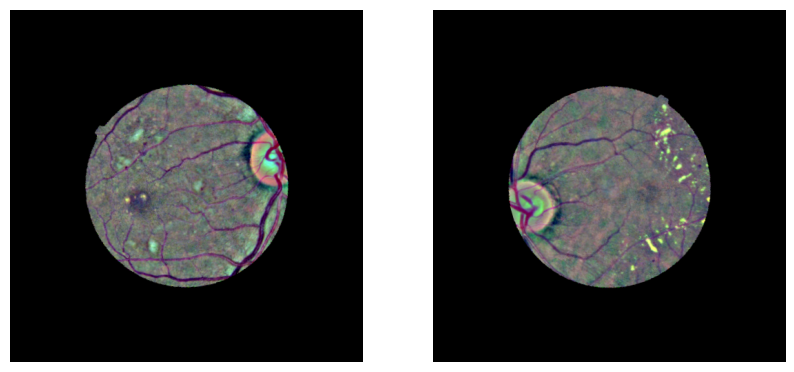

In [33]:
plt.figure(figsize=(10,6))
for i in range(len(img)):
    plt.subplot(1,2,i+1), plt.imshow(img[i])
    plt.axis('off')
plt.show()

# Model

In [13]:
def get_model(parameters):
    base_model = keras.applications.VGG16(
                                    weights=parameters['weights'],  
                                    input_shape=parameters['input_shape_model'],
                                    include_top=parameters['include_top'])

    base_model.trainable = parameters['trainable']


    # Freezing weights
    x = base_model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x)
    x = Dropout(parameters['dropout'])(x)
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
    x = Dropout(parameters['dropout'])(x)
    outputs = tf.keras.layers.Dense(1, activation=parameters['output_activation'])(x)
    model = keras.Model(inputs=base_model.input, outputs=outputs)

    return model

# Probar por separado Adaboost customized

In [37]:
n_estimators=10
epochs=1
bdt_real_test_CNN = Ada_CNN(
    base_estimator=get_model(params),
    n_estimators=n_estimators,
    learning_rate=1,
    epochs=epochs)

In [22]:
X1,y1 = next(training_generator)

(2, 512, 512, 3)


In [23]:
n_samples = X1.shape[0]

In [24]:
n_samples

2

In [104]:
sample_weight = np.ones(n_samples) / n_samples

In [26]:
sample_weight

array([0.5, 0.5])

In [97]:
base_estimator0 = get_model(params)

In [28]:
from keras.models import Sequential

In [98]:
config=base_estimator0.get_config()
#estimator = Models.model_from_config(config)
estimator1 = Sequential.from_config(config)


weights = base_estimator0.get_weights()
estimator1.set_weights(weights)
estimator1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
from sklearn.preprocessing import LabelBinarizer


In [31]:
lb=LabelBinarizer()
y_b = lb.fit_transform(y1)

Hace el fit en el sample training (batch) por cada n_estimator

In [100]:
estimator1.fit(X1, y_b, sample_weight=sample_weight, epochs = 1, batch_size = 2)

1/1 [==============================] - 6s 6s/step - loss: 0.2958 - accuracy: 0.5000


In [117]:
y_pred = estimator1.predict(X1) # 2 imgs, 2 predictions


1/1 [==============================] - 1s 1s/step


In [119]:
y_b

array([[0],
       [1]])

In [118]:
y_pred

array([[0.33740652],
       [0.32109648]], dtype=float32)

In [102]:
y_pred_l = np.where(y_pred>0.5,1,0)
incorrect = y_pred_l != y_b
estimator_error = np.dot(incorrect.reshape(1,-1), sample_weight) / np.sum(sample_weight, axis=0)


In [103]:
estimator_error

array([0.50028561])

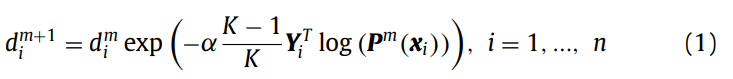

In [106]:
from numpy.core.umath_tests import inner1d
sample_weight = sample_weight*np.exp(-1. * bdt_real_test_CNN.learning_rate_ * (((2 - 1) / 2) *
                                                        inner1d(y_b, np.log(
                                                            y_pred)))) 

sample_weight_sum = np.sum(sample_weight, axis=0)
sample_weight /= sample_weight_sum



In [107]:
sample_weight

array([0.36169687, 0.63830313])

In [109]:
base_estimator1= estimator1
config=base_estimator1.get_config()
#estimator = Models.model_from_config(config)
estimator2 = Sequential.from_config(config)


weights = base_estimator1.get_weights()
estimator2.set_weights(weights)
estimator2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [133]:
h = estimator2.fit(X1, y_b, sample_weight=sample_weight, epochs = 1, batch_size = 2)

1/1 [==============================] - 6s 6s/step - loss: 1569.8411 - accuracy: 0.5000


In [134]:
h.history['accuracy']

[0.5]

In [111]:
y_pred = estimator2.predict(X1) # 2 imgs, 2 predictions

1/1 [==============================] - 1s 1s/step


In [112]:
y_pred

array([[1.],
       [1.]], dtype=float32)

In [113]:
y_pred_l = np.where(y_pred>0.5,1,0)
incorrect = y_pred_l != y_b
estimator_error = np.dot(incorrect.reshape(1,-1), sample_weight) / np.sum(sample_weight, axis=0)

In [120]:
incorrect

array([[ True],
       [False]])

In [114]:
estimator_error

array([0.36169687])

In [115]:
sample_weight = sample_weight*np.exp(-1. * bdt_real_test_CNN.learning_rate_ * (((2 - 1) / 2) *
                                                        inner1d(y_b, np.log(
                                                            y_pred)))) 

sample_weight_sum = np.sum(sample_weight, axis=0)
sample_weight /= sample_weight_sum

In [116]:
sample_weight

array([0.36169687, 0.63830313])

# Customized adaboost

In [88]:
# #%% Setting parameters for the model


# tf.keras.backend.clear_session()
# WANDB_STORAGE = params['name_modelo'] + f'{specific_time}'
# wandb_storage_dir = WANDB_STORAGE

# run = wandb.init(project='Retinopatia MI', entity='piashiba', config=params, job_type='train', name=f'{specific_time} modelo retinopatia')
# os.environ['WANDB_DIR'] = wandb_storage_dir
# os.environ['WANDB_CACHE_DIR'] = wandb_storage_dir
# os.environ['WANDB_CONFIG_DIR'] = wandb_storage_dir

# config = wandb.config

In [101]:
n_estimators=10
epochs=1
bdt_real_test_CNN = Ada_CNN(
    base_estimator=get_model(config),
    n_estimators=n_estimators,
    learning_rate=1,
    epochs=epochs,
    )

In [102]:
tf.keras.backend.clear_session()

bdt_real_test_CNN.fit(training_generator=training_generator)
#wandb.finish()
#test_real_errors_CNN=bdt_real_test_CNN.estimator_errors_[:]


0 Nueva iteración de batches...
1/1 [==============================] - 2s 2s/step
y_pred: 
 [[7.341577e-14]
 [2.138650e-13]] y_true: 
 [[0]
 [0]]
incorrect: 
 [[False]
 [False]]  Sample weight: 
 [0.5 0.5]
estimator_error:  [0.]
1 Nueva iteración de batches...
1/1 [==============================] - 1s 1s/step
y_pred: 
 [[0.53020954]
 [0.5300748 ]] y_true: 
 [[0]
 [1]]
incorrect: 
 [[ True]
 [False]]  Sample weight: 
 [0.5 0.5]
estimator_error:  [0.5]
1/1 [==============================] - 1s 1s/step
y_pred: 
 [[0.6529222 ]
 [0.65295064]] y_true: 
 [[0]
 [1]]
incorrect: 
 [[ True]
 [False]]  Sample weight: 
 [0.42131717 0.57868283]
estimator_error:  [0.42131717]
1/1 [==============================] - 1s 1s/step
y_pred: 
 [[0.5912732 ]
 [0.58872044]] y_true: 
 [[0]
 [1]]
incorrect: 
 [[ True]
 [False]]  Sample weight: 
 [0.37040134 0.62959866]
estimator_error:  [0.37040134]
1/1 [==============================] - 1s 1s/step
y_pred: 
 [[0.99942464]
 [0.9995993 ]] y_true: 
 [[0]
 [1]]
incor

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/block2_conv2/Conv2D/Conv2DBackpropFilter' defined at (most recent call last):
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\UsuarioHI\AppData\Local\Temp\ipykernel_19740\518456141.py", line 3, in <module>
      bdt_real_test_CNN.fit(training_generator=training_generator)
    File "c:\Users\UsuarioHI\Adaboost\adaboostCNN_customized\customized_adaboost.py", line 160, in fit
      sample_weight, estimator_weight, estimator_error = self.boost(X, y, sample_weight)
    File "c:\Users\UsuarioHI\Adaboost\adaboostCNN_customized\customized_adaboost.py", line 187, in boost
      return self.real_boost(X, y, sample_weight)
    File "c:\Users\UsuarioHI\Adaboost\adaboostCNN_customized\customized_adaboost.py", line 209, in real_boost
      estimator.fit(X, y_b, sample_weight=sample_weight, epochs = self.epochs, batch_size = self.batch_size)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\wandb\integration\keras\keras.py", line 174, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\wandb\integration\keras\keras.py", line 174, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\wandb\integration\keras\keras.py", line 174, in new_v2
      return old_v2(*args, **kwargs)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 577, in minimize
      loss, var_list=var_list, grad_loss=grad_loss, tape=tape
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 635, in _compute_gradients
      tape, loss, var_list, grad_loss
    File "c:\Users\UsuarioHI\anaconda3\envs\diabeticpatia\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/block2_conv2/Conv2D/Conv2DBackpropFilter'
OOM when allocating tensor with shape[1,65536,1152] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model/block2_conv2/Conv2D/Conv2DBackpropFilter}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_206514]

In [103]:
bdt_real_test_CNN.metrics

AttributeError: 'AdaBoostClassifier' object has no attribute 'metrics'

In [ ]:
best_m